# Introduction to Unsupervised Learning

In this lab you will work with **unsupervised learning**. Unsupervised learning attempts to find inherent structure or relationships in complex data. Unsupervised learning does not use labeled cases in contrast with supervised learning. 

There are number of approaches to unsupervised learning. In this lab you will work with two widely used **clustering** methods, **K-means clustering** and **hierarchical**.

## K-means clustering

K-means clustering separates a dataset into K clusters of equal variance. The number of clusters, K, is user defined. The basic algorithm has the following steps:
1. A set of K centroids are randomly chosen. 
2. Clusters are formed by minimizing variance within each cluster. This metric is also know as the **within cluster sum of squares** (see further discussion in the section on evaluating clusters). This step partitions the data into clusters with minimum squared distance to the centroid of the cluster. 
3. The centroids are moved to mean of each cluster. The means of each cluster is computed and the centroid is moved to the mean. 
4. Steps 2 and 3 are repeated until a stopping criteria is met. Typically, the algorithm terminates when the within cluster variance decreases only minimally. 
5. The above steps are repeated starting with a random start of step 1. The best set of clusters by within cluster variance and between cluster separation are retained.  

Since K-means clustering relies only on basic linear algebra operations, the method is massively scalable. Out-of-core K-means clustering algorithms are widely used. However, this method assumes equal variance of the clusters, a fairly restrictive assumption. In practice, this criteria is almost never true, and yet K-means clustering still produces useful results. 

## Hierarchical clustering

Hierarchical clustering methods make fewer distributional assumptions when compared to K-means methods. However, K-means methods are generally more scalable, sometimes very much so. 

Hierarchical clustering creates clusters by either a **divisive** method or **agglomerative** method. The divisive method is a "top down" approach starting with the entire dataset and then finding partitions in a stepwise manner.  The later method is known as agglomerative clustering is a "bottom up** approach. In this lab you will work with agglomerative clustering which roughly works as follows:
1. The **linkage distances** between each of the data points is computed.
2. Points are clustered pairwise with their nearest neighbor. 
3. Linkage distances between the clusters are computed.
4. Clusters are combined pairwise into larger clusters.
5. Steps 3 and 4 are repeated until all data points are in a single cluster. 

The linkage function can be computed in a number of ways:
- **Ward** linkage measures the increase in variance for the clusters being linked,
- **Average** linkage uses the mean pairwise distance between the members of the two clusters, 
- **Complete** or **Maximal** linkage uses the maximum distance between the members of the two clusters.

Several different distance metrics are used to compute linkage functions:
- **Euclidian** or **l2** distance is the most widely used. This metric is only choice for the Ward linkage method. 
- **Manhattan** or **l1** distance is robust to outliers and has other interesting properties. 
- **Cosine** similarity, is the dot product between the location vectors divided by the magnitudes of the vectors. Notice that this metric is a measure of similarity, whereas the other two metrics are measures of difference. Similarity can be quite useful when working with data such as images or text documents. 

## A first example

With the above bit of theory in mind, you will now apply both K-means and agglomerative clustering modes to a set of synthetic data. 

First, execute the code in the cell below to load the packages required to run the rest of this notebook. 

In [1]:
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

%matplotlib inline

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The code in the  cell below creates synthetic data from bivariate Normal distribution with mean of $\{ 0,0 \}$ and a covariance matrix:

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.4 \\
  0.4 & 1.0
 \end{bmatrix}$$
 
 Execute this code.

In [2]:
def make_dist(mean, cov, dist_num, n = 100, seed = 123):
    nr.seed(seed)
    sample = nr.multivariate_normal(mean, cov, n) # Compute the 2-d Normally distributed data
    sample = np.column_stack((sample, np.array([dist_num]*n))) ## Add the distribution identifier
    print('Shape of sample = ' + str(sample.shape))
    return(sample)

cov = np.array([[1.0, 0.4], [0.4, 1.0]])
mean = np.array([0.0, 0.0])
sample1 = make_dist(mean, cov, 1)

Shape of sample = (100, 3)


Execute the code in the cell below to create simulate data from two difference distributions. 

In [3]:
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
mean = np.array([3.0, 0.0])
sample2 = make_dist(mean, cov, 2, 100, 3344)

mean = np.array([-3.0,0.0])
cov = np.array([[1.0,0.8],[0.8,1.0]])
sample3 = make_dist(mean, cov, 3, 100, 5566)

Shape of sample = (100, 3)
Shape of sample = (100, 3)


Execute the code in the cell below to display the data simulated from the three distributions.

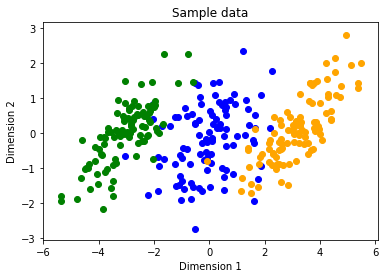

In [4]:
def plot_dat(sample1, sample2, sample3):
    plt.scatter(sample1[:,0], sample1[:,1], color = 'blue')
    plt.scatter(sample2[:,0], sample2[:,1], color = 'orange')
    plt.scatter(sample3[:,0], sample3[:,1], color = 'green')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Sample data')
    plt.show()
    
plot_dat(sample1, sample2, sample3)  

Notice that the three distributions are mostly separated, with some overlap.

Execute the code in the cell below to concatenate the data from the three numpy arrays and Z-Score normalize the feature columns. This is a vital step for any 

In [5]:
sample = np.concatenate((sample1, sample2, sample3))

for i in range(1):
    mean_col = np.mean(sample[:,i])
    std_col = np.std(sample[:,i])
    sample[:,i] = [(x - mean_col)/std_col for x in sample[:,i]]

sample.shape

(300, 3)

Next, you will create a K-means clustering model by the following steps in the code below:
1. A K-means clustering model is defined with K = 3. 
2. The model is fit to the data and cluster assignments computed. 
3. The assignments to the clusters are printed. 

Execute this code. 

In [6]:
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(sample[:,0:2])
print(assignments_km3)

[0 1 0 2 1 2 1 2 1 1 0 0 2 1 2 1 2 1 0 2 2 0 0 1 0 2 1 0 0 1 0 1 1 0 2 1 1
 2 0 2 1 1 2 2 1 1 0 0 2 1 1 0 0 1 1 0 0 1 2 1 2 0 1 1 1 2 0 1 0 1 2 1 1 0
 0 0 2 2 1 1 0 0 1 1 0 2 2 0 1 0 0 1 1 2 0 0 0 1 0 0 1 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0
 0 0 0 0]


Execute the code in the cell below to plot the locations of the cluster assignments. 

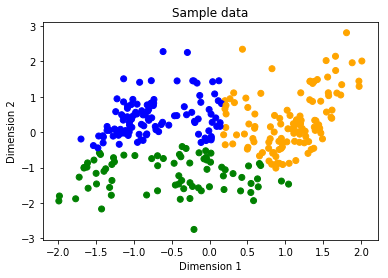

In [7]:
def plot_clusters(sample, assignment):
    col_dic = {0:'blue',1:'green',2:'orange',3:'gray',4:'magenta',5:'black'}
    colors = [col_dic[x] for x in assignment]
    plt.scatter(sample[:,0], sample[:,1], color = colors)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Sample data')
    plt.show()

plot_clusters(sample, assignments_km3)

Examine this plot. The k-means clustering algorithm has found a structure in the data which is quite different from the distributions used to generate them. None the less, these clusters look reasonable given the structure of the data. The clusters separate the data into three fairly tight regions.  

Now you will compare the result of the K-means clustering with agglomerative clustering. The code in the cell below performs the following processing:
1. Defines an agglomerative clustering model with three clusters.
2. Fits the model and computes the cluster assignments. 

Execute this code. 

In [8]:
agglomerative_3 = AgglomerativeClustering(n_clusters=3)
assignments_ag3 = agglomerative_3.fit_predict(sample[:,0:2])

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Execute the code in cell below to visualize the cluster assignments for the agglomerative models. 

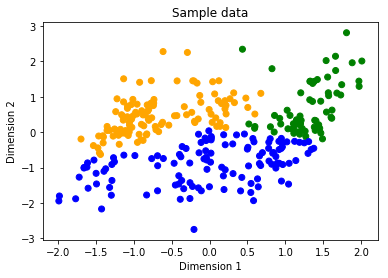

In [9]:
plot_clusters(sample, assignments_ag3)

The results for the agglomerative clustering model are noticeably different from those created by the k-means model. The agglomerative clusters deviate from the approximately elliptical clusters created by the k-means algorithm. 

The foregoing 3 cluster models were applied to the three simulated distributions. What will be the result of using other numbers of clusters? 

Execute the code in the cell below to compute a K-means cluster model, with K=4, and display the assignments.

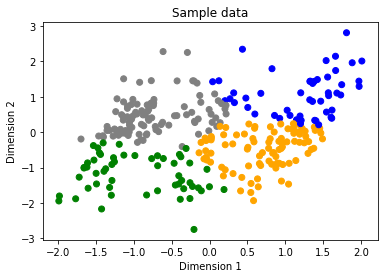

In [10]:
kmeans_4 = KMeans(n_clusters=4, random_state=0)
assignments_km4 = kmeans_4.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_km4)

To compare the K-means model with an agglomerative clustering model with two clusters, execute the code in the cell below. 

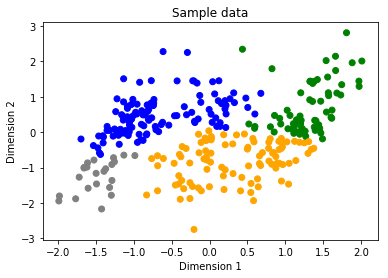

In [11]:
agglomerative_4 = AgglomerativeClustering(n_clusters=4)
assignments_ag4 = agglomerative_4.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_ag4)

Compare these results to each other and to the 3 cluster models. As expected, the 4 cluster models exhibit smaller clusters showing greater detail of the structure of the data. The structure discovered is noticeably different between the k-means and the agglomerative model. 

Next, you will explore the differences between K-means and agglomerative clustering methods with 5 clusters. Execute the code in the cell below to compute the K=5 K-means model and display the assignments. 

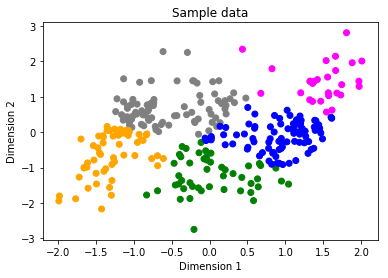

In [12]:
kmeans_5 = KMeans(n_clusters=5, random_state=0)
assignments_km5 = kmeans_5.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_km5)

Next, execute the code in the cell below to compute and display the assignments for an agglomerative clustering model with 5 clusters.

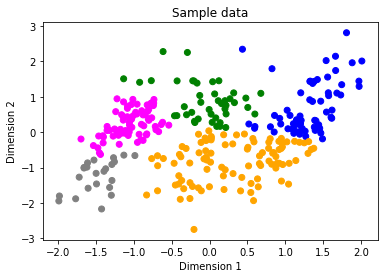

In [13]:
agglomerative_5 = AgglomerativeClustering(n_clusters=5)
assignments_ag5 = agglomerative_5.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_ag5)

Examine the differences between the assignments for the K-means and agglomerative clustering methods. Notice that the K-means method has created 5 clusters which clearly different structure for the agglomerative model. Each model highlights a different aspect of the structure of the data. 

## Evaluating cluster models

Now that you have created some clustering models, you are likely wondering how can you evaluate these models and perform model selection. There are a number of metrics you can use to evaluate and compare clustering models. However, you should always keep in mind that the best model, should be selected based on the problem you are trying to solve.

One useful metric for clusters is the **within cluster sum of squares** or **WCSS**. Intuitively, clusters should have minimal dispersion and therefore minimal WCSS. The  

$$WCSS = Min \sum_i \sum_{j\ in\ cluster\ i} ||x_j - c_i||^2 \\
where\\
c_i = center\ of\ ith\ cluster\\ 
and\\
||x_j - c_i|| = distance\ between\ data\ x_j\ and\ center\ c_i
$$

We can use WCSS to compare different cluster models. Models with smaller SSW have tighter clusters and, therefore smaller WCSS. 

****
**Note:** WCSS is also referred to as **inertia**. 
****

The **between cluster sum of squares** or **BCSS** is a related metric. Whereas WCSS measures how tight the clusters are BCSS is a measure of the separation between the clusters. To compute the BCSS, observe that the **total sum of squares** or **TSS** must equal the sum of the WCSS and BCSS:

$$
TSS = BCSS + WCSS\\
where\\
TSS = \sum_i (x_i - \mu)^2\\
where\\
\mu = mean\ of\ all\ data\ samples
$$

Notice that the TSS is just the variance of all data points. The BCSS is then just the difference between TSS and WCSS.

The **silhouette coefficient** or **SC** is another clustering metric. The silhouette coefficient measures the ratio between the distances within a cluster and distances to the nearest adjacent cluster. The SC for the $ith$ member of a cluster is computed as follows:

$$
SC_i = \frac{b_i -a_i }{max(a_i, b_i)}\\
where\\
a_i = average\ distance\ from\ point\ i\ to\ other\ members\ of\ the\ same\ cluster\\
b_i = average\ distance\ from\ point\ i\ to\ members\ of\ an\ adjacent\ cluster
$$

The SC has some important properties First, the SC values are limited as a result of the normalization:

$$\{ -1 \le SC \le 1 \}$$

For the case where the clusters are compact and well separated from adjacent clusters the following relationship holds:

$$if\ a_i \lt b_i\ then\ SC \gt 0$$

However,  for dispersed clusters that are not well separated from adjacent clusters the following relationship holds:

$$if\ a_i \gt b_i\ then\ SC \lt 0$$

In other words, the tighter the cluster and the further it is from members of the adjacent cluster. The closer the SC values will be to 1. However, if the cluster is dispersed and the distances to the adjacent cluster is small, the SC will have a value less than 0. 

In summary, you want to find a model with SC values close to 1. If the SC is consistently less than zero the clustering model is probably not that useful. 

****
**Note:** The WCSS and BCSS metrics have the concept of the clustering having multivariate-Normal distributions. Therefore, these metrics are strictly only applicable to K-means cluster. This fact means that WCSS and BCSS are not useful metrics for agglomerative clustering. The SC can be computed using various metrics so is more generally applicable to most clustering methods. 
****

In the previous section, you compared cluster models using visualization of the cluster assignments. The code in the cell below computes and displays WCSS and BCSS for the three K-means clustering models tried. Execute this code and examine the result.  

[218.11892006217795, 157.80708909786227, 122.86119030810536]
[300.]


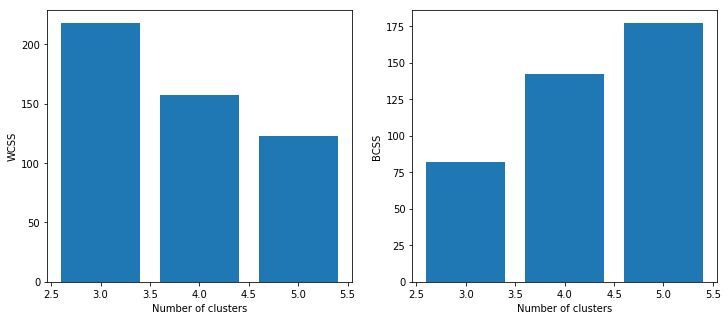

In [14]:
km_models = [kmeans_3, kmeans_4, kmeans_5]

def plot_WCSS_km(km_models, samples):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in km_models]
    print(wcss)
    n_clusts = [x+1 for x in range(2,len(wcss) + 2)]
    ax[0].bar(n_clusts, wcss)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    ## Plot BCSS
    tss = np.sum(sample[:,0:1]**2, axis = 0)
    print(tss)
    ## Compute BCSS as TSS - WCSS
    bcss = np.concatenate([tss - x for x in wcss]).ravel()
    ax[1].bar(n_clusts, bcss)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    plt.show()
    

plot_WCSS_km(km_models, sample)

Examine these results and notice the following:
1. The WCSS deceases with the number of clusters, whereas the BCSS increases with the number of clusters. This behavior is expected. Using more clusters results in smaller clusters with lower WCSS. However, the separation between the clusters decrease with larger number of clusters leading to increased BCSS. 
2. The WCSS decreases significantly between 3 and 4 clusters. The changes in both metrics are less between the 4 and 5 cluster model. 
3. These metrics indicate there is not a great difference between the 4 and 5 cluster models. However, the 3 cluster  model appears to be inferior. 

The code in the cell below computes and displays the SC for the three M-means models. This code uses the `silhouette_score` function from the scikit-learn `metrics` package. Execute this code and examine the result. 

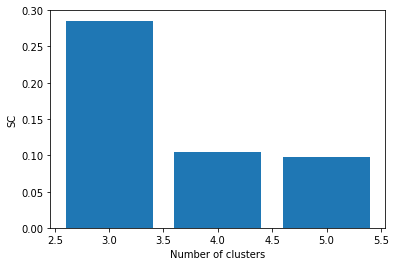

In [15]:
assignment_list = [assignments_km3, assignments_km4, assignments_km5]

def plot_sillohette(samples, assignments, x_lab = 'Number of clusters', start = 3):
    silhouette = [silhouette_score(samples[:,0:1], a) for a in assignments]
    n_clusts = [x + start for x in range(0, len(silhouette))]
    plt.bar(n_clusts, silhouette)
    plt.xlabel(x_lab)
    plt.ylabel('SC')
    plt.show()

plot_sillohette(sample, assignment_list)

The SC decreases with increasing numbers of clusters. The 4 and 5 cluster models have rather low SC. 

Taken together the three metrics indicate that the k=5 k-means model is the most representative. While the k=3 model has higher SC, the WCSS is greater and the BCSS is lower.

The exploration with the k-means clustering model can be extended to greater numbers of clusters. 

The code in the cell below computes and displays the SC for the three agglomerative clustering models. Execute this code and examine the results.

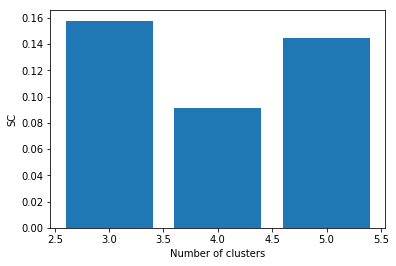

In [16]:
assignment_list = [assignments_ag3, assignments_ag4, assignments_ag5]
plot_sillohette(sample, assignment_list)

The SC is similar for the 3 and 5 cluster model. It appears the 5 cluster model has created finer divisions of the original 3 clusters. This behavior is expected for hierarchical clustering models. Cluster divisions in these models are based on a split of at tree structure. 

## Another example

The foregoing examples provide a basic introduction to K-means and agglomerative clustering. In this section you will work with another set of synthetic data and explore how changes in distance metric and linkage function change agglomerative clustering results. 

The code in the cell below computes another synthetic dataset comprised of three distributions. One of these distributions has a much larger covariance than in the previous example. This fact will stress the equal variance assumption of the K-means clustering model. 

Execute this code to generate and display the dataset. 

Shape of sample = (100, 3)
Shape of sample = (100, 3)
Shape of sample = (100, 3)


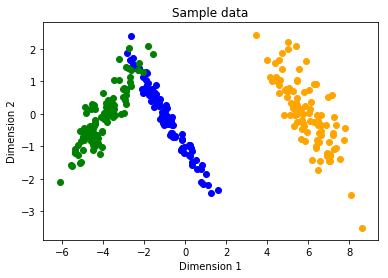

In [17]:
nr.seed(3344)
cov = np.array([[1.0, -0.98], [-0.98, 1.0]])
mean = np.array([-1.0, 0.0])
sample1 = make_dist(mean, cov, 1, 100, 3344)

nr.seed(5566)
cov = np.array([[1.0, -0.8], [-0.8, 1.0]])
mean = np.array([6.0, 0.0])
sample2 = make_dist(mean, cov, 1, 100, 6677)

nr.seed(7777)
cov = np.array([[1.0, 0.9], [0.9, 1.0]])
mean = np.array([-4.0, 0.0])
sample3= make_dist(mean, cov, 3, 100, 367)

## Plot the distributions
plot_dat(sample1, sample2, sample3) 

As expected the dataset is comprised of three distinct distributions. The distribution in the center exhibits high covariance. 

Now, execute the code in the cell below to concatenate the three distributions into a single numpy array and Z-Score normalize the features. 

In [18]:
sample_2 = np.concatenate((sample1, sample2, sample3))

for i in range(1):
    mean_col = np.mean(sample_2[:,i])
    std_col = np.std(sample_2[:,i])
    sample_2[:,i] = [(x - mean_col)/std_col for x in sample_2[:,i]]

sample_2.shape

(300, 3)

A K=3 K-means model is a useful basis for comparison. Execute the code in the cell below to compute the model and display the cluster assignments.

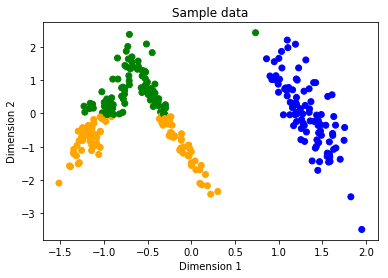

0.38136155568785596


In [19]:
nr.seed(3344)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments_km3)
print(silhouette_score(sample_2[:,0:1], assignments_km3))

The k=3 K-means cluster model has largely separated the data on the right and split the data distributions on the left. 

Now, compute an 3-cluster agglomerative model using Ward linkage and Euclidean distance norms (the defaults in scikit-learn) by executing the code in the cell below. 

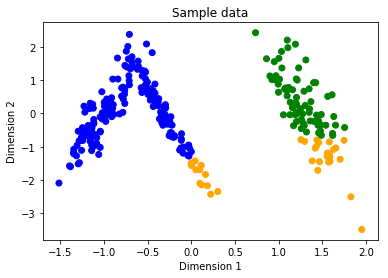

In [20]:
nr.seed(3344)
agglomerative3_w = AgglomerativeClustering(n_clusters=3)
assignments3_w = agglomerative3_w.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_w)

The cluster assignments displayed above mostly link the original distributions. However certain points are linked into a new cluster in the lower right. 

But, what will be the effect of using other linkage functions? To find out, execute the code in the cell below to compute and display the assignments of a 3-cluster agglomerative model using average linkage.

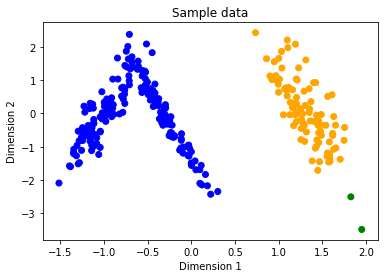

In [21]:
nr.seed(5555)
agglomerative3_a = AgglomerativeClustering(n_clusters=3, linkage = 'average')
assignments3_a = agglomerative3_a.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a)

The cluster assignments Follow the structure of the data rather well. Two outlying points in the lower right for the third cluster.

Now, execute the code in the cell below to compute and display the cluster assignments for a 3-cluster agglomerative model using complete or maximal linkage. 

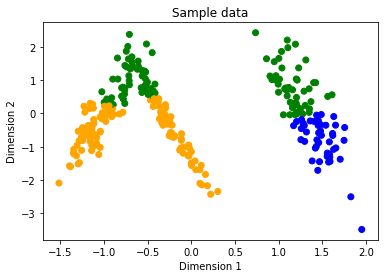

In [22]:
nr.seed(987)
agglomerative3_c = AgglomerativeClustering(n_clusters=3, linkage = 'complete')
assignments3_c = agglomerative3_c.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_c)

These cluster assignments are quite different from those seen before. However, the assignments seem a bit discordant with the data. 

Having tried several linkage functions, you will now explore using different distance metrics. The code in the cell below computes a 3-cluster agglomerative model with average linkage using the Manhattan or l1 distance metric. Execute this code and examine the class assignments displayed.

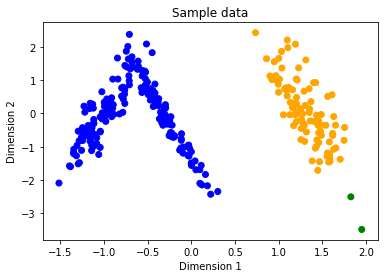

In [23]:
nr.seed(3344)
agglomerative3_a_m = AgglomerativeClustering(n_clusters=3, linkage = 'average', affinity = 'manhattan')
assignments3_a_m = agglomerative3_a_m.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a_m)

These assignments are identical to those obtained with average linkage and Euclidean distance.

There are some other combinations of distance metric and linkage which might be tried. In this case, only average linkage and cosine similarity will be tried. Execute the code in the cell below to compute and display the assignments for a 3-cluster agglomerative model using average linkage and cosine similarity.

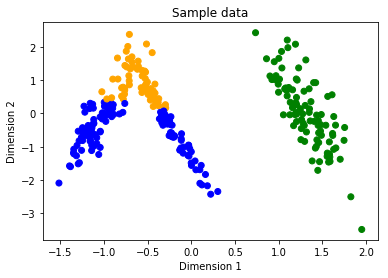

In [24]:
nr.seed(234)
agglomerative3_a_c = AgglomerativeClustering(n_clusters=3, linkage = 'average', affinity = 'cosine')
assignments3_a_c = agglomerative3_a_c.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a_c)

As with the other metric choices, the division the data into these assignments appears a bit arbitrary. 

Finally, compute the SCs for each of these models and compare them by executing the code in the cell below.

Then, answer **Question 1** on the course page.

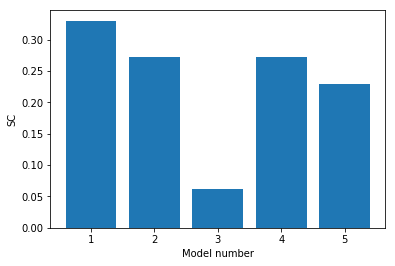

In [25]:
assignment_list = [assignments3_w, assignments3_a, assignments3_c, assignments3_a_m, assignments3_a_c]
plot_sillohette(sample, assignment_list, x_lab = 'Model number', start = 1)

The first model with Ward linkage and Euclidean distance has the highest SC. The three cluster modules using average linkage and Euclidean or Manhattan distance are nearly as good. It is clear from the foregoing, that the choice of distance metric and linkage can have significant effect on the results of agglomerative clustering.  

## Summary

In this lab you have worked with two commonly used clustering models, K-means clustering and hierarchical agglomerative clustering. These methods are examples of unsupervised learning since they attempt to find interesting structure in data without using labels or marked cases.

For agglomerative cluster models the linkage can be any of:
- **Ward** or increase in variance,
- **Average** linkage or mean pairwise distance between the members of pairs of clusters, 
- **Complete** or **Maximal** linkage or maximum distance between the members of the two clusters.

Several different distance metrics are used to compute linkage functions:
- **Euclidian** or **l2**, 
- **Manhattan** or **l1**, 
- **Cosine** similarity.

A critical problem for clustering models is to determine the number of clusters. Since there are no labels, model selection must be performed by a combination of visualization and metrics. Metrics used for evaluating cluster models include:
- The **within cluster sum of squares (WCSS)** and **between cluster sum of squares (BCSS)** are used for K-means clustering only. Ideally a good K-menas cluster model should have small WCSS and large BCSS. 
- Most any clustering model can be evaluated using **silhouette coefficient (SC)**. The SC measures the ratio between the distances within a cluster and distances to the nearest adjacent cluster.